# NEW YORK CITY TAXI - ANALYSIS, RECOMMENDATIONS, PREDICTIONS

# <font color="teal">PART 4 - MACHINE LEARNING MODEL FOR EARNINGS AND HOTSPOTS</font>

This part of research targets construction of Machine Learning model to predict average taxi owner earnings density per location, hours and weekday, to map hotspots and make optimal choices trying to be at the right time at the right spot.

## Objective
Research on Questions using Predictive Modelling approach:

1) If you were a taxi owner, how would you maximize your earnings in a day?

2) If you were a taxi owner, how would you minimize your work time while retaining the average wages earned by a typical taxi in the dataset?

3) If you run a taxi company with 10 taxis, how would you maximize your earnings?

## Approach
Caonstruct Random Forest predictive analytics model for Average Revenue per location per time and rank the locations to be able to select best spots at given time.

# 4.1. Get Data

In [ ]:
library('lubridate')
library('dplyr')
library('rlang')
library("ggplot2")
library("ggmap")
library('plyr')
library("sqldf")

In [2]:
############### Read Data from files #################################
trips <- read.csv("trips_notebook.csv")
head(trips, 5)

X hack_license                     pickup_datetime     dropoff_datetime   
1 1 AD8751110E6292079EB10EB9481FE1A6 2013-04-04 18:47:45 2013-04-04 19:00:25
2 2 E1B595FD55E4C82C1E213EB17438107A 2013-04-04 17:59:50 2013-04-04 18:21:48
3 3 16BB0D96A0DCC853AEC7F55C8D6C71E0 2013-04-04 18:12:01 2013-04-04 18:25:24
4 4 579C41EA5EC846F8B641A42F9EE3E855 2013-04-04 20:12:57 2013-04-04 20:29:55
5 5 1B4E92431F9DA4D49874EC76E769E874 2013-04-05 02:48:11 2013-04-05 02:51:21
  trip_time_in_secs trip_distance pickup_longitude pickup_latitude
1  759              2.5           -73.95785        40.76532       
2 1318              3.6           -73.98288        40.75499       
3  799              1.9           -73.97812        40.76345       
4 1017              3.6           -74.00637        40.74475       
5  189              0.7           -73.98519        40.75493       
  dropoff_longitude dropoff_latitude fare_amount tip_amount total_amount
1 -73.97627         40.78565         11.0        2.50       15.00       
2 -74.00919         40.71537         16.5        3.60       21.60       
3 -73.95567         40.77664         10.0        3.45       14.95       
4 -73.96166         40.76108         15.0        3.20       19.20       
5 -73.99078         40.74800          4.5        1.10        6.60       
  pickup_hour pickup_weekday
1 18          5             
2 17          5             
3 18          5             
4 20          5             
5  2          6

In [3]:
## Remove contraversial data with the same pickup and dropoff location for some trips
trips <- subset(trips, (pickup_longitude != dropoff_longitude) | (pickup_latitude != dropoff_latitude))

# 4.2. Calculate Daily, Total and Average Figures

In [4]:
totalDays <- n_distinct(lubridate::date(trips$pickup_datetime))

# Number of taxis
nofTaxis <- n_distinct(trips$hack_license)

# Total profit
totalProfit <- sum(trips$total_amount)

# Average earnings per taxi
avEarningsPerTaxi <- totalProfit/nofTaxis
avTaxiProfitPerDay <- avEarningsPerTaxi/totalDays

In [5]:
print(sprintf("totalDays = %s", totalDays))
print(sprintf("nofTaxis = %s", nofTaxis))
print(sprintf("totalProfit = %s", totalProfit))
print(sprintf("avEarningsPerTaxi = %s", avEarningsPerTaxi))
print(sprintf("avTaxiProfitPerDay = %s", avTaxiProfitPerDay))

[1] "totalDays = 30"
[1] "nofTaxis = 32893"
[1] "totalProfit = 213954376.6"
[1] "avEarningsPerTaxi = 6504.55648922265"
[1] "avTaxiProfitPerDay = 216.818549640755"


# 4.3. Data Aggregation for pickup spots and hours

In [186]:
CreateSpotsHourMap <- function (minNofPickups = 9) {
  # Consolidate Spots and Revenue per Spot per Week per Hour
  return(subset(sqldf(sprintf("SELECT ROUND(pickup_longitude, 2) AS long,
                        ROUND(pickup_latitude, 2) AS lat,
                        pickup_weekday, pickup_hour,
                        COUNT(*) AS num_pickups,
                        sum(total_amount) AS total_revenue,
                        avg(total_amount) AS av_revenue
                        FROM trips
                        WHERE trip_time_in_secs > 0
                        GROUP BY lat, long, pickup_weekday, pickup_hour
                        HAVING COUNT(*) > %s
                        ORDER BY pickup_weekday, pickup_hour", minNofPickups)
  )))
}
spots <- CreateSpotsHourMap()
head(spots)
nrow(spots)

long   lat   pickup_weekday pickup_hour num_pickups total_revenue av_revenue
1 -74.03 40.62 1              0            10           188.80      18.88000  
2 -73.79 40.64 1              0           139          6909.35      49.70755  
3 -73.78 40.64 1              0           238         10401.15      43.70231  
4 -73.96 40.65 1              0            10           198.50      19.85000  
5 -73.79 40.65 1              0           101          5575.57      55.20366  
6 -73.78 40.65 1              0           210          9392.19      44.72471

[1] 19484

In [187]:
write.csv(spots, "largespots2.csv") # retain for future use in Visualisation Tools

# 4.4. Build ML Model for Average Revenue per location and hour

## 4.4.1. Hypothesis

Evaluate whether Random Forest model can accuaretely predict Average Earnings per location per hour

## 4.4.2. Extract and Enrich Model Data

In [188]:
modelData <- spots[, c("av_revenue", "pickup_hour", "pickup_weekday", "long", "lat" )]

## 4.4.3. Geohashing and digitizing locations

In [189]:
# Introduce categorical pickup code columns based on geohashing
library ('geohash')

# Converting geocodes into hashcodes
modelData$pickup_code  <- as.factor(geohash::gh_encode(modelData$lat,  modelData$long))
modelData$pickup_number = as.numeric(as.factor(modelData$pickup_code))

In [190]:
str(modelData)
head(modelData, 12)

'data.frame':	19484 obs. of  7 variables:
 $ av_revenue    : num  18.9 49.7 43.7 19.9 55.2 ...
 $ pickup_hour   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ pickup_weekday: int  1 1 1 1 1 1 1 1 1 1 ...
 $ long          : num  -74 -73.8 -73.8 -74 -73.8 ...
 $ lat           : num  40.6 40.6 40.6 40.6 40.6 ...
 $ pickup_code   : Factor w/ 182 levels "dr5r56","dr5r7v",..: 1 138 139 21 143 149 16 17 20 22 ...
 $ pickup_number : num  1 138 139 21 143 149 16 17 20 22 ...


av_revenue pickup_hour pickup_weekday long   lat   pickup_code pickup_number
1  18.88000   0           1              -74.03 40.62 dr5r56        1          
2  49.70755   0           1              -73.79 40.64 dr5x0y      138          
3  43.70231   0           1              -73.78 40.64 dr5x1n      139          
4  19.85000   0           1              -73.96 40.65 dr5rkb       21          
5  55.20366   0           1              -73.79 40.65 dr5x2b      143          
6  44.72471   0           1              -73.78 40.65 dr5x30      149          
7  19.55474   0           1              -74.00 40.66 dr5rk1       16          
8  17.50263   0           1              -73.99 40.66 dr5rk3       17          
9  19.65024   0           1              -73.98 40.66 dr5rk9       20          
10 19.07256   0           1              -73.96 40.66 dr5rkc       22          
11 22.34667   0           1              -74.00 40.67 dr5rk5       18          
12 18.12986   0           1              -73.99 40.67 dr5rk7       19

## 4.4.4. Random Forest Model - separation Train and Test data

In [191]:
library('randomForest')
library('caret')

In [192]:
# Separate train and test_data
sm <- sample(nrow(modelData), 2*nrow(modelData)/3) # Select randomly from trips allocating 2/3 to train and 1/3 to test data

# Try different model selections to check the accuracy of Tip predicability
train_data = modelData[sm,]

# make weekday and hour as categorical variables
#train_data$pickup_weekday <- as.factor(train_data$pickup_weekday) ######## Explore
#train_data$pickup_hour <- as.factor(train_data$pickup_hour)

head(train_data, 2)

# Test dataset
test_data = modelData[-sm,]
#test_data$pickup_weekday <- as.factor(test_data$pickup_weekday)
#test_data$pickup_hour <- as.factor(test_data$pickup_hour)
head(test_data, 2)

av_revenue pickup_hour pickup_weekday long   lat   pickup_code
6005 15.23346    2          3              -73.99 40.70 dr5rs3     
7311 14.05974   14          3              -74.01 40.75 dr5rgf     
     pickup_number
6005 42           
7311 12

av_revenue pickup_hour pickup_weekday long   lat   pickup_code pickup_number
1 18.88000   0           1              -74.03 40.62 dr5r56        1          
3 43.70231   0           1              -73.78 40.64 dr5x1n      139

## 4.4.5. Random Forest Model Regression

In [193]:
# Call Random Forest regression
#rf <- randomForest(av_revenue ~ pickup_code + pickup_hour + pickup_weekday, train_data, ntree = 500)
rf <- randomForest(av_revenue ~ pickup_number + pickup_hour + pickup_weekday, train_data, ntree = 500)
rf
#str(rf)


Call:
 randomForest(formula = av_revenue ~ pickup_number + pickup_hour +      pickup_weekday, data = train_data, ntree = 500) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 1

          Mean of squared residuals: 13.75971
                    % Var explained: 85.48

IncNodePurity
pickup_number  869350.642   
pickup_hour     39254.202   
pickup_weekday   9898.483

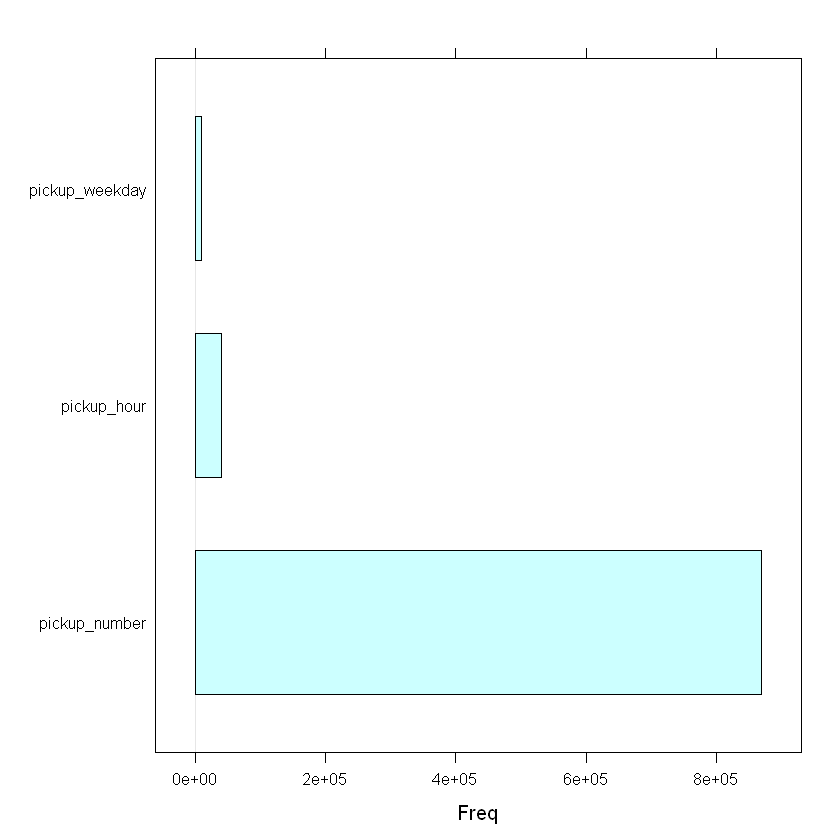

In [194]:
rf$importance ## Print factors importance
barchart(rf$importance) ## Print factors importance

<font color="maroon">Observe - Location is a major factor in defining AvEarnings, followed by hour and weekday</font>

In [195]:
# Accuracy factors
caret::postResample(rf$predicted, train_data$av_revenue)

RMSE  Rsquared       MAE 
3.7094080 0.8902992 2.4555208

## 4.4.6. Run Predictions against test dataset

In [196]:
predict(rf, test_data) -> prediction
caret::postResample(prediction, test_data$av_revenue)

RMSE  Rsquared       MAE 
3.6609299 0.8795749 2.4005124

<font color="maroon">Observe - accuracy of model (R^2); 91% for Large Aggregations (0.1 digit geocode); 88% for Medium Aggregations (0.01 digit geocode)</font>

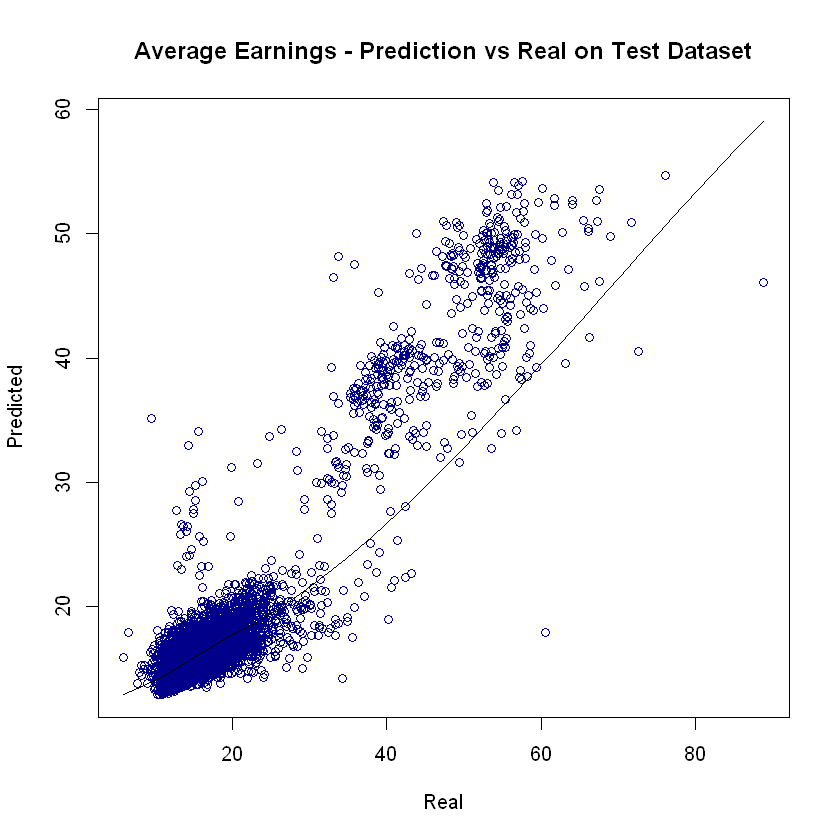

In [197]:
# Show scatter plot predicted vs real
dt <- data.frame(keyName=names(prediction), value=prediction, row.names=NULL)
scatter.smooth(test_data$av_revenue, dt$value, ylab="Predicted", xlab="Real", 
               main = "Average Earnings - Prediction vs Real on Test Dataset", col="darkblue")

## 4.4.7. Random Forest Model summary

### <font color="maroon"><b>For large aggregation areas, RF Model delivers good accuracy of trained model against train and test datasets with R^2 ~ 0.85-0.90.</b></font>
It can be confidently used for future predictions.

# 4.5. Average Earnings Calculator based on trained model

In [207]:
CalcAvEarnings <- function (long, lat, hour, weekday) {
  # Based on trained model, Calculate average driver revenue for given pickup spots for a particular weekday and hour
  
  # Calculate pickup code using geocodes hash
  pickup_code   <- geohash::gh_encode(round(lat,2), round(long,2))
  # find pickup_number for the geohashcode (ideally it should be the part of global geoservice)
  pickup_number <- as.numeric(modelData[modelData$pickup_code==pickup_code,][1,]$pickup_number)

  #print(sprintf("pickup_code = %s, pickup_number= %s", pickup_code, pickup_number))

  if (!is.na(pickup_number))  {
      nr <- nrow(test_data)    
      #test_data[nr + 1, c('pickup_code', 'pickup_hour', 'pickup_weekday')] <- c(pickup_code, hour, weekday)
      test_data[nr + 1, c('pickup_number', 'pickup_hour', 'pickup_weekday')] <- c(pickup_number, hour, weekday)

      av = predict(rf, newdata = test_data[nr + 1,])
  }
    
  return(av)
}

In [209]:
# Test Calculator
CalcAvEarnings(-73.99094, 40.73605, hour=23, weekday=2)  # Union Square
CalcAvEarnings(-73.863,   40.769,   hour=16, weekday=4)  # Airport
CalcAvEarnings(-73.99094, 40.73605, hour=23, weekday=6)  # Manhatten Sat

6496 
14.2863

6496 
41.62758

6496 
14.71573

In [210]:
## 4.6. Data Enrichment with Predited AvEarnings based on trained model
for (i in 1:nrow(spots)) {
    spots$av_revenue_predict[i] <- CalcAvEarnings(long = spots$long[i], lat = spots$lat[i], 
                                           hour = spots$pickup_hour[i], weekday = spots$pickup_weekday[i])
    spots$total_revenue_predict[i] <- as.numeric(spots$av_revenue_predict[i] * spots$num_pickups[i])
}
head(spots)

long   lat   pickup_weekday pickup_hour num_pickups total_revenue av_revenue
1 -74.03 40.62 1              0            10           188.80      18.88000  
2 -73.79 40.64 1              0           139          6909.35      49.70755  
3 -73.78 40.64 1              0           238         10401.15      43.70231  
4 -73.96 40.65 1              0            10           198.50      19.85000  
5 -73.79 40.65 1              0           101          5575.57      55.20366  
6 -73.78 40.65 1              0           210          9392.19      44.72471  
  av_revenue_predict total_revenue_predict
1 17.44964            174.4964            
2 34.03012           4730.1869            
3 33.94798           8079.6196            
4 17.12770            171.2770            
5 34.72029           3506.7496            
6 34.03019           7146.3398

# 4.6. <font color="green">Hotspots Calculator</font> for given hour and location

In [213]:
GetNearbyHotSpots <- function (long, lat, weekday, hour, nof_records = 5) {
  # Get spots close to given spot for a particular weekday and hour
  query = sprintf("SELECT long, lat, av_revenue_predict, num_pickups, 
                  SQRT(SQUARE(long-(%s)) + SQUARE(lat-(%s))) AS Dist
                  FROM spots
                  WHERE ROUND(long, 1) = ROUND(%s, 1) AND ROUND(lat, 1) == ROUND(%s, 1)
                        AND pickup_weekday=%s AND pickup_hour=%s
                  ORDER BY av_revenue_predict DESC, Dist, num_pickups DESC", long, lat, long, lat, weekday, hour)
  # print(query)
  return(subset(sqldf(query))[1:nof_records,])
}

In [214]:
# Examples:
GetNearbyHotSpots(-73.78726, 40.64111 , 1, 0)
GetNearbyHotSpots(-74.023, 40.766, 3, 8)
GetNearbyHotSpots(-73.94, 40.75, 6, 11)

long   lat   av_revenue_predict num_pickups Dist       
1  -73.79 40.65 34.72029           101         0.009302672
2  -73.78 40.65 34.03019           210         0.011477792
3  -73.79 40.64 34.03012           139         0.002956298
4  -73.78 40.64 33.94798           238         0.007344365
NA     NA    NA       NA            NA                  NA

long   lat   av_revenue_predict num_pickups Dist      
1 -73.95 40.83 19.06951           183         0.09708244
2 -73.95 40.82 16.78297           101         0.09080198
3 -73.95 40.75 16.49643            13         0.07473286
4 -73.95 40.81 16.29792           160         0.08523497
5 -73.95 40.76 16.24422           122         0.07324616

long   lat   av_revenue_predict num_pickups Dist      
1 -73.86 40.77 39.10244            794        0.08246211
2 -73.87 40.77 37.82471           1375        0.07280110
3 -73.88 40.77 37.59485             51        0.06324555
4 -73.89 40.77 37.38999            152        0.05385165
5 -73.94 40.84 22.02543             77        0.09000000

In [215]:
GetNearbyHotSpots(-73.99094, 40.73605, weekday = 1, hour = 8) ### Union Square

long   lat   av_revenue_predict num_pickups Dist      
1 -74.02 40.72 18.98721            59         0.03319768
2 -74.02 40.70 18.70203            10         0.04630428
3 -74.01 40.70 18.37412           129         0.04077850
4 -74.02 40.71 18.18561           289         0.03902674
5 -74.01 40.71 17.99736           550         0.03227826

In [216]:
gc()

used      (Mb)   gc trigger (Mb)   max used  (Mb)  
Ncells   5196740  277.6  12852624   686.5  18205633  972.3
Vcells 220888887 1685.3 715258200  5457.0 894067730 6821.2

### <font color="maroon">Observation - Calculator picks up nearby hot spots</font>

## 4.7. Visualize City Taxi Revenue Heatmap

In [223]:
# Use external script to Draw maps
source('MapPalette.R')

In [249]:
DrawMap <- function(ds, chartLabel = "Total Revenue for NYC Taxis by Pickup Location", thresHold = 10^5) 
{
  # Helper function to make bins not show if total revenue is below threshold
    total_rev <- function(x, minLevel = thresHold) {
    if (sum(x) < minLevel) {return (NA)}
        else {return (sum(x))}
  }
  plot <- ggplot(ds, aes(x=long, y=lat, z=total_revenue_predict)) +
    geom_point(size=0.1, color="#999999") +
    stat_summary_hex(fun = total_rev, bins=100, alpha=0.5) +
    scale_x_continuous(limits=c(-74.0224, -73.8521)) +
    scale_y_continuous(limits=c(40.6959, 40.8348)) +
    theme_map_dark() +
    scale_fill_gradient(low="#FFFFFF", high="#E74C3C", labels=dollar, trans="log", breaks=c(10^(6:8))) +
    labs(title = chartLabel) + coord_equal()

  #png("nyc-taxi-rev.png", w=900, h=900, res=300)
  plot
  #dev.off()
}

In [227]:
# Find average revenue accross all hotspots
print(av <- mean(spots$av_revenue_predict))

[1] 18.22567


In [228]:
#DrawMap(spots)

## 4.8. Ranking of top predicted hotspots (for a particular date)

In [235]:
RankHotSpots <- function(hour, weekday, nofRecords = 5) {
    ## Rank of spots from top to bottom for given hour
    sub = subset(spots, pickup_hour == hour & pickup_weekday == weekday)
    return(sub[order(sub$av_revenue_predict, decreasing = TRUE),][1:nofRecords,])
}

In [240]:
RankHotSpots(23, 6) ## Saturday Night -> should be clustered arount City
RankHotSpots(0, 3)  ## Wed 3am -> City never sleeps

long   lat   pickup_weekday pickup_hour num_pickups total_revenue
16296 -73.78 40.65 6              23          685         37104.25     
16295 -73.79 40.65 6              23          253         14001.38     
16293 -73.79 40.64 6              23          301         15241.48     
16294 -73.78 40.64 6              23          247         11961.98     
16300 -73.79 40.66 6              23           12           580.89     
      av_revenue av_revenue_predict total_revenue_predict
16296 54.16679   46.04454           31540.5075           
16295 55.34142   45.69386           11560.5455           
16293 50.63615   45.02112           13551.3562           
16294 48.42907   44.66120           11031.3171           
16300 48.40750   44.11890             529.4268

long   lat   pickup_weekday pickup_hour num_pickups total_revenue
5748 -73.79 40.65 3              0           405         23001.74     
5746 -73.79 40.64 3              0           441         24391.49     
5750 -73.79 40.66 3              0            15           772.67     
5747 -73.78 40.64 3              0           429         21780.78     
5749 -73.78 40.65 3              0           650         32729.84     
     av_revenue av_revenue_predict total_revenue_predict
5748 56.79442   40.83818           16539.4633           
5746 55.30950   40.74367           17967.9575           
5750 51.51133   40.54170             608.1256           
5747 50.77105   39.47655           16935.4389           
5749 50.35360   38.46465           25002.0221

## 4.9. Optimising work time while retaining average wages

Question - If you were a taxi owner, how would you minimize your work time while retaining the average wages earned by a typical taxi in the dataset? 

Suggestion - Work only the best hours. Technical solution - Ranking hotspots by average predicted hourly earnings, with filter above the average wages accross the dataset

### 4.9.1. Revenue distribution by hour

In [241]:
#####################################################################################################################
RevenueByHour <- function(nof_taxis) {
  # Average Wages by Hour
  return (subset(sqldf(sprintf("SELECT pickup_hour as hour, sum(total_revenue_predict)/%s AS revenue_driver
                               FROM spots
                               GROUP BY pickup_hour
                               ORDER BY pickup_hour", nof_taxis)
        )))
}
revByHour <- RevenueByHour(nofTaxis)

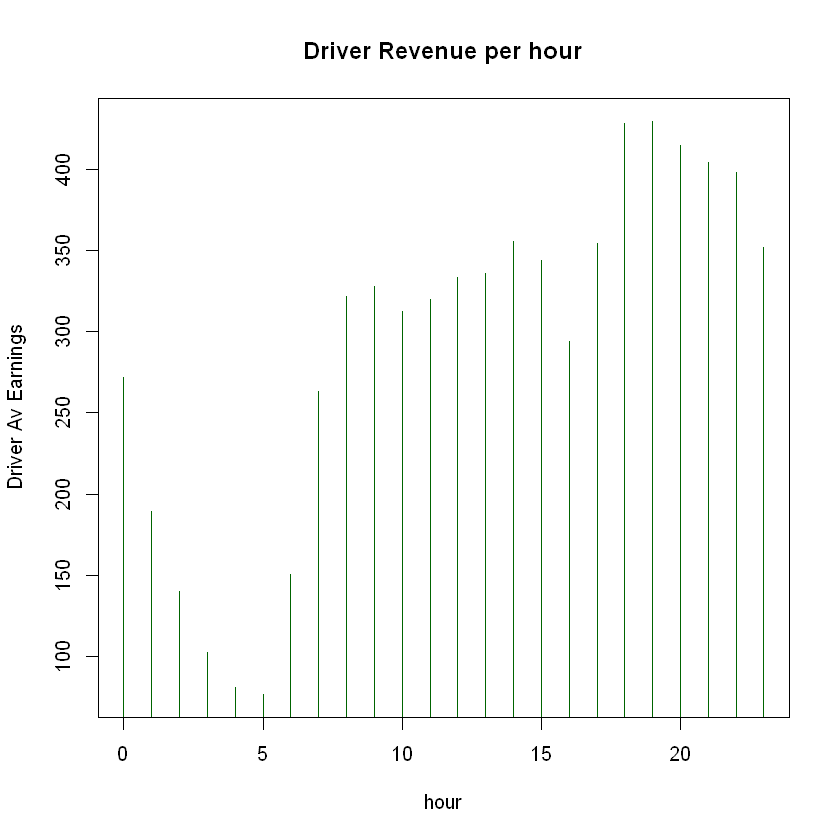

In [242]:
#barchart(table(revByHour$hour, revByHour$revenue_driver))
#barplot(table(revByHour$hour, revByHour$revenue_driver))

plot(revByHour$hour, revByHour$revenue_driver, type="h", main = "Driver Revenue per hour", 
     col="darkgreen", xlab="hour", ylab="Driver Av Earnings")
#revByHour

## 4.9.2. Best working hours to earn above average wages

In [243]:
# Select hours where the earnings is above the average Earnings Per Taxi an hour
recommemdedHours <- subset(revByHour, revenue_driver > avEarningsPerTaxi/24)
#recommemdedHours

In [244]:
# Best Earning Hours
recommemdedHours[order(recommemdedHours$revenue_driver, decreasing = TRUE),]

hour revenue_driver
20 19   429.3901      
19 18   428.1960      
21 20   414.7002      
22 21   403.9552      
23 22   397.9253      
15 14   355.2893      
18 17   354.0610      
24 23   351.7049      
16 15   343.6696      
14 13   335.7825      
13 12   333.5510      
10  9   327.6372      
9   8   321.8550      
12 11   319.4323      
11 10   312.0948      
17 16   294.0402      
1   0   271.9243

### <font color='maroon'>Recommendations - work evenings 17-23, sleep at night 1-7, may start morning - 8am onwards</font>

In [251]:
### 3.7.2. Top hotspots for a particular area
#DrawMap(spots[spots$pickup_hour == 5,], "TOP HOTSPOTS AT MIDNIGHT", thresHold = 10^3)

## 4.10. Optimisation of earnings for a Taxi Company

#### <font color='darkblue'>Question - If you run a taxi company with 10 taxis, how would you maximize your earnings?</font>

Suggestion 1 - Diversify earnings by spreading operations across different clusters

### 4.10.1. Clustering city areas

In [252]:
gc()
spots$cluster <- NULL
#####################################################################################################################
# Clustering locations to identify 10 areas with busy locations
#####################################################################################################################
km.out = kmeans(spots[,1:2], 10, nstart=20, iter.max = 100)

used      (Mb)   gc trigger (Mb)   max used  (Mb)  
Ncells   5197889  277.6  12852624   686.5  18205633  972.3
Vcells 220905381 1685.4 715258200  5457.0 894067730 6821.2

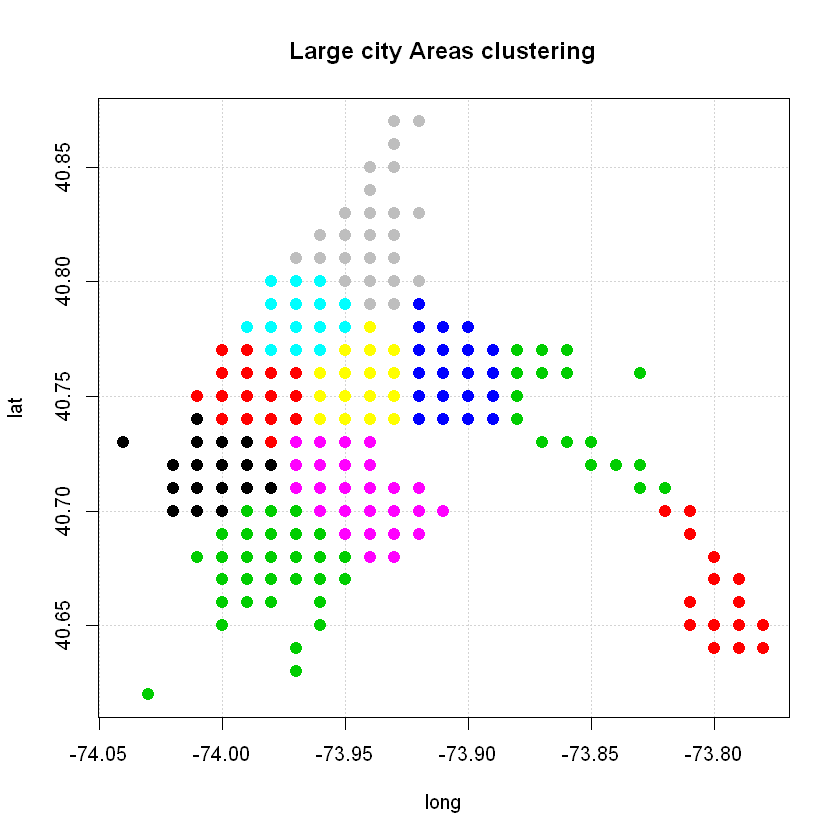

In [258]:
plot(spots[,1:2], col=(km.out$cluster+1), main="Large city Areas clustering", pch=20, cex=2, panel.first=grid())

In [254]:
# Merge cluster in Spots
spots$cluster = km.out$cluster
head(spots)

long   lat   pickup_weekday pickup_hour num_pickups total_revenue av_revenue
1 -74.03 40.62 1              0            10           188.80      18.88000  
2 -73.79 40.64 1              0           139          6909.35      49.70755  
3 -73.78 40.64 1              0           238         10401.15      43.70231  
4 -73.96 40.65 1              0            10           198.50      19.85000  
5 -73.79 40.65 1              0           101          5575.57      55.20366  
6 -73.78 40.65 1              0           210          9392.19      44.72471  
  av_revenue_predict total_revenue_predict cluster
1 17.44964            174.4964             2      
2 34.03012           4730.1869             1      
3 33.94798           8079.6196             1      
4 17.12770            171.2770             2      
5 34.72029           3506.7496             1      
6 34.03019           7146.3398             1

### 4.10.2. Identify hotspots in every cluster

In [255]:
# Print hotspot for every cluster
for (nc in 1:10) {
    spc = subset(spots, cluster == nc)
    topspot = spc[order(spc$av_revenue_predict, decreasing = TRUE),][1,]
    print(sprintf('cluster %s -> best hour: %s, best day: %s, revenue %s', nc, 
          topspot$pickup_hour, topspot$pickup_weekday,  topspot$av_revenue_predict))
}

[1] "cluster 1 -> best hour: 17, best day: 5, revenue 57.4439792997316"
[1] "cluster 2 -> best hour: 6, best day: 4, revenue 21.5812666281575"
[1] "cluster 3 -> best hour: 17, best day: 4, revenue 40.6074092612532"
[1] "cluster 4 -> best hour: 4, best day: 2, revenue 20.4885664699412"
[1] "cluster 5 -> best hour: 6, best day: 6, revenue 18.5409310239058"
[1] "cluster 6 -> best hour: 16, best day: 2, revenue 30.7188746826369"
[1] "cluster 7 -> best hour: 15, best day: 5, revenue 22.7675182094039"
[1] "cluster 8 -> best hour: 4, best day: 6, revenue 25.2086141208372"
[1] "cluster 9 -> best hour: 5, best day: 5, revenue 19.535851038316"
[1] "cluster 10 -> best hour: 16, best day: 4, revenue 46.8015951145229"


In [257]:
write.csv(spots, "hotspots_model.csv") # retain for future use in Visualisation Tools

# Conclusion

Machine Learning algorithms allows buidling predictive models to extract valuable information from Big Data and provide predictive recommendations for drivers, taxi company owners, city planners and travellers. 
The technical soluton includes dynamic heatmaps, hotspot calculators, city clusters, reusable models for fast calculation of earning for every hotspot and identification of nearest hotspots.
A recommendation to taxi owners is to work optimal hours, pickup best hotspots and minimise waiting time by moving to next hotspot around current location. A recommendatior to Taxi Companies is to diversify a fleet accross major city clusters.
Making money in taxi business is to be in the right time at the right space, and science can help with that.